<a href="https://colab.research.google.com/gist/qbeer/07eb98879a555a676b6da86ea8cd7f9e/hw_6_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import metrics
from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

https://datasetsearch.research.google.com/search?query=leopards&docid=L2cvMTFqOWMya244eg%3D%3D

## 1. Implement a linear model
return the weight parameters w = (w1, w2, ... , wP) and the intercept parameter w0 separately where:

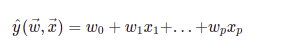

* check your returned coefficients with the built in `LinearRegression` class from the sklearn library, they should be within tolerance 1e-6 to each other

* use a generated regression dataset from `sklearn.dataset import make_regression` API with parameters `n_samples=1000` and `n_features=20`

$\omega = \left(X^T X\right)^{-1}X^T y$

In [3]:
#From the 4th homework, we used an analytical solver, https://docs.google.com/presentation/d/13kZ1kwNrlbuA6B5Ax-YCrjCuN7Db48Ed/edit#slide=id.p10
def analLinRegression(X, y):
    coefs = np.matmul(np.linalg.inv(np.matmul(X.T,X)),np.matmul(X.T,y))
    X0 = np.vstack((X.T,np.diag(np.diag(np.ones(len(y)))))).T
    intercept = np.matmul(np.linalg.inv(np.matmul(X0.T,X0)),np.matmul(X0.T,y))[-1]
    return coefs, intercept
def intercepts(coefs, y, X):
    #y = a*x + b, we need 'b'
    return np.mean(y) - np.matmul(coefs, np.mean(X, axis=0))

In [4]:
from sklearn.datasets import make_regression

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [5]:
X, y = make_regression(n_samples=1000, n_features=20)

In [6]:
reg = LinearRegression().fit(X,y)
print(reg.coef_, reg.intercept_)

[ 3.73821506e+01 -7.10542736e-14  1.94321381e-14  5.21750031e+01
 -1.01331058e-14  8.77403656e+00  5.08618245e+01  6.57936133e+01
 -1.34677271e-14  5.77487349e+01 -4.80313233e-15 -3.13034034e-14
  4.03566206e-15  1.35950055e-14  1.57029407e-14  6.75368238e+00
  5.82059318e+01  3.55271368e-15  3.94094959e+01  2.04615888e+01] -8.881784197001252e-16


In [7]:
analLinRegression(X,y)

(array([ 3.73821506e+01, -6.66133815e-15, -3.44169138e-15,  5.21750031e+01,
        -1.99840144e-15,  8.77403656e+00,  5.08618245e+01,  6.57936133e+01,
        -6.66133815e-16,  5.77487349e+01, -1.33226763e-15,  6.21724894e-15,
         2.22044605e-15,  2.99760217e-15,  8.88178420e-16,  6.75368238e+00,
         5.82059318e+01, -7.43849426e-15,  3.94094959e+01,  2.04615888e+01]),
 -5.329070518200751e-15)

In [8]:
np.abs(analLinRegression(X,y)[0]-reg.coef_) < 1e-6

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [284]:
#plt.scatter(analLinRegression(X,y)[0],reg.coef_, marker='x')
#plt.plot([0,max(reg.coef_)],[0,max(reg.coef_)], 'g--')

In [10]:
intercepts(analLinRegression(X,y)[0], y, X)

1.7763568394002505e-15

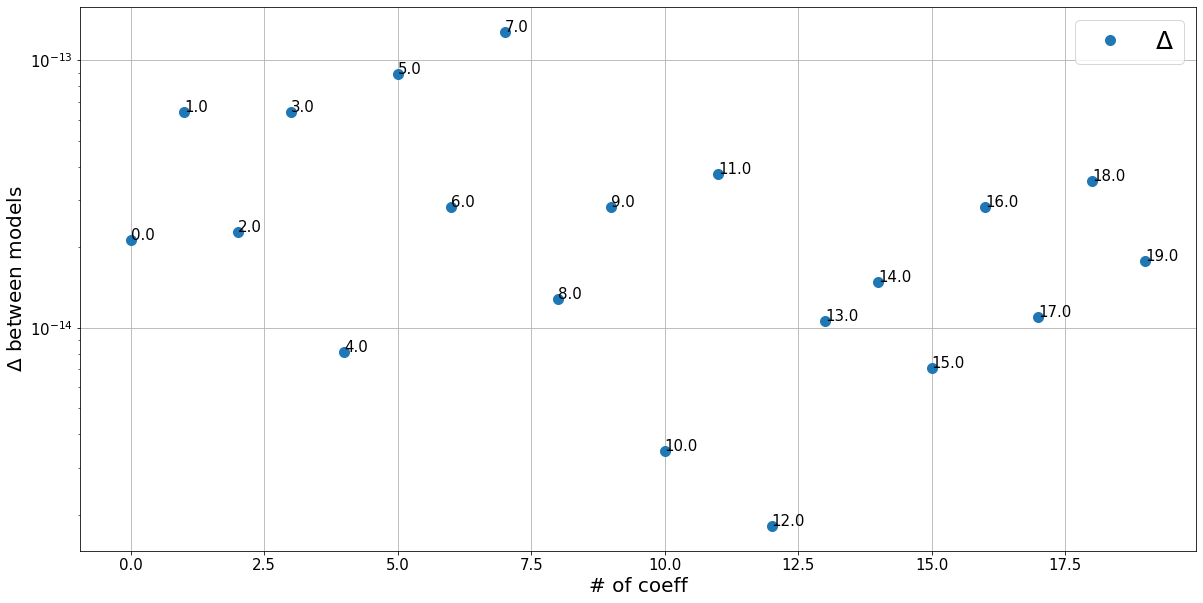

In [11]:
plt.figure(figsize=(20,10))
plt.plot(np.abs(analLinRegression(X,y)[0]-reg.coef_),'o', markersize=10, label=r'$\Delta$')
#plt.plot(reg.coef_,'*', markersize=15)
plt.yscale('log')
#plt.ylim(1e-18, 1e5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid(True)
plt.legend(fontsize=25)
plt.xlabel('# of coeff', fontsize=20)
plt.ylabel(r'$\Delta$ between models', fontsize=20)
text=np.linspace(0,19,20)
delta=np.abs(analLinRegression(X,y)[0]-reg.coef_)
for i in range(20):
    plt.annotate(text[i], xy=(text[i],delta[i]),fontsize=15)


## 2. Use of real data

* download the [Communities and Crime Data Set](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime) from UCI, the task includes understanding the dataset: naming the appropiate data fields, handling missing values, etc.

* split the data in training/test sets and fit a LinearRegression model with 5-fold cross-validation on top of it - compare training and testing scores (R^2 by default) for the different CV splits, print the mean score and its standard deviation

* fit the best Lasso regression model with 5-fold grid search cross validation (GridSearchCV) on the parameters: alpha, normalize, max_iter and show the best parameters

### Tidying up
#### All numeric data was normalized into the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. 

In [12]:
def value_integerizer(dataframe, column):
    col_name, _ = np.unique(dataframe[column].astype(str),return_counts=True)
    dataframe[column] = dataframe[column].replace(to_replace=col_name, value=([x+1 for x in range(len(col_name))]))
    print(col_name)
    return dataframe

In [68]:
column_names = pd.read_csv('communities.names',skiprows=73, sep=' ', nrows=128, dtype=str)['@relation'].values
column_names

array(['state', 'county', 'community', 'communityname', 'fold',
       'population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome',
       'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec',
       'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc',
       'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap',
       'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov',
       'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed',
       'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu',
       'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
       'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par',
       'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par',
       'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg',
       'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRe

In [14]:
data = pd.read_csv('communities.data', header=None, na_values='?')
display(data.head())
data.columns = column_names
display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 128 entries, state to ViolentCrimesPerPop
dtypes: float64(125), int64(2), object(1)
memory usage: 1.9+ MB


In [16]:
data = value_integerizer(data,'communityname')

['Aberdeencity' 'Aberdeentown' 'Aberdeentownship' ... 'Yucaipacity'
 'Yukoncity' 'Zanesvillecity']


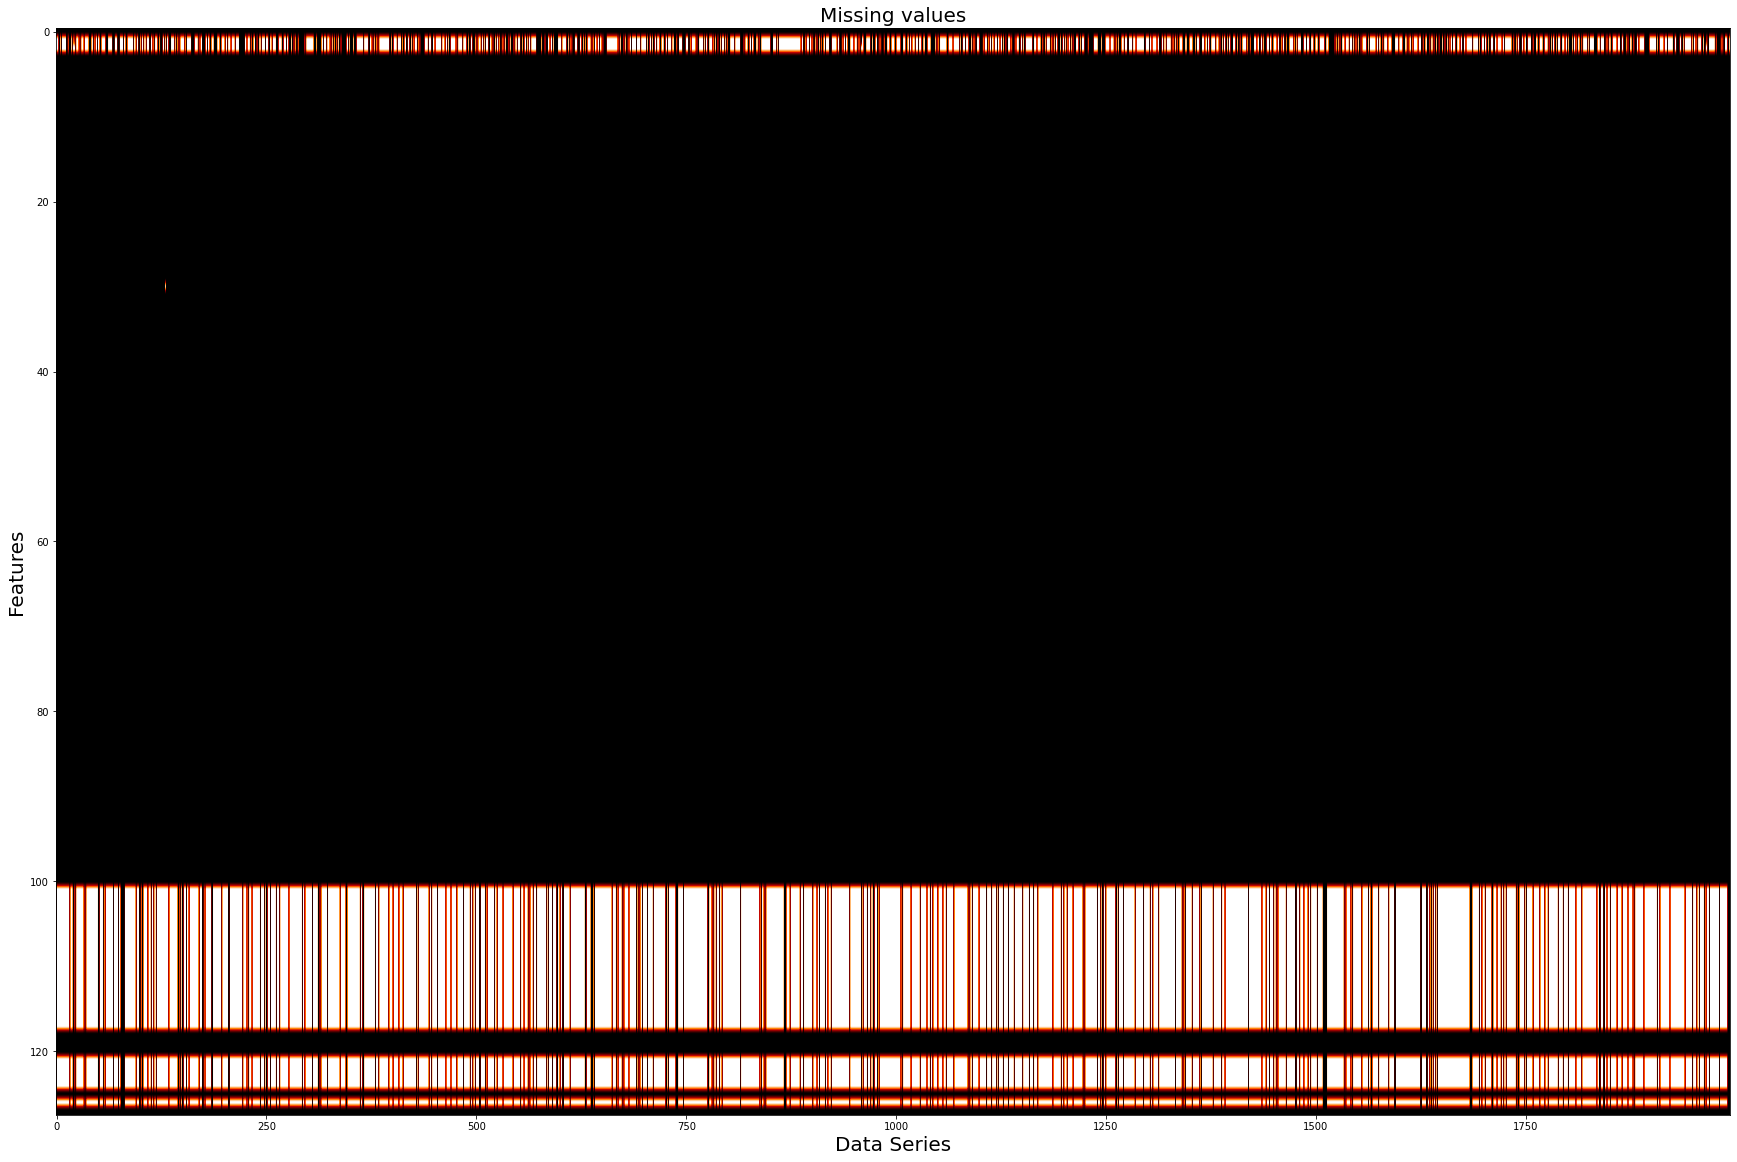

In [74]:
plt.figure(figsize=(30, 20))
plt.title('Missing values', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.xlabel('Data Series', fontsize=20)
plt.imshow(data.isna().T, cmap='gist_heat',aspect='auto')

In [84]:
keep_rows = data.isna().sum(1)[data.isna().sum(1) < 24].index.values

#dropping rows that have more than 24 NA
filtered_data = data[data.index.isin(keep_rows)].dropna(axis="columns", inplace=False)

In [87]:
#dropping columns
filtered_data = filtered_data.dropna(axis=1,how='any')

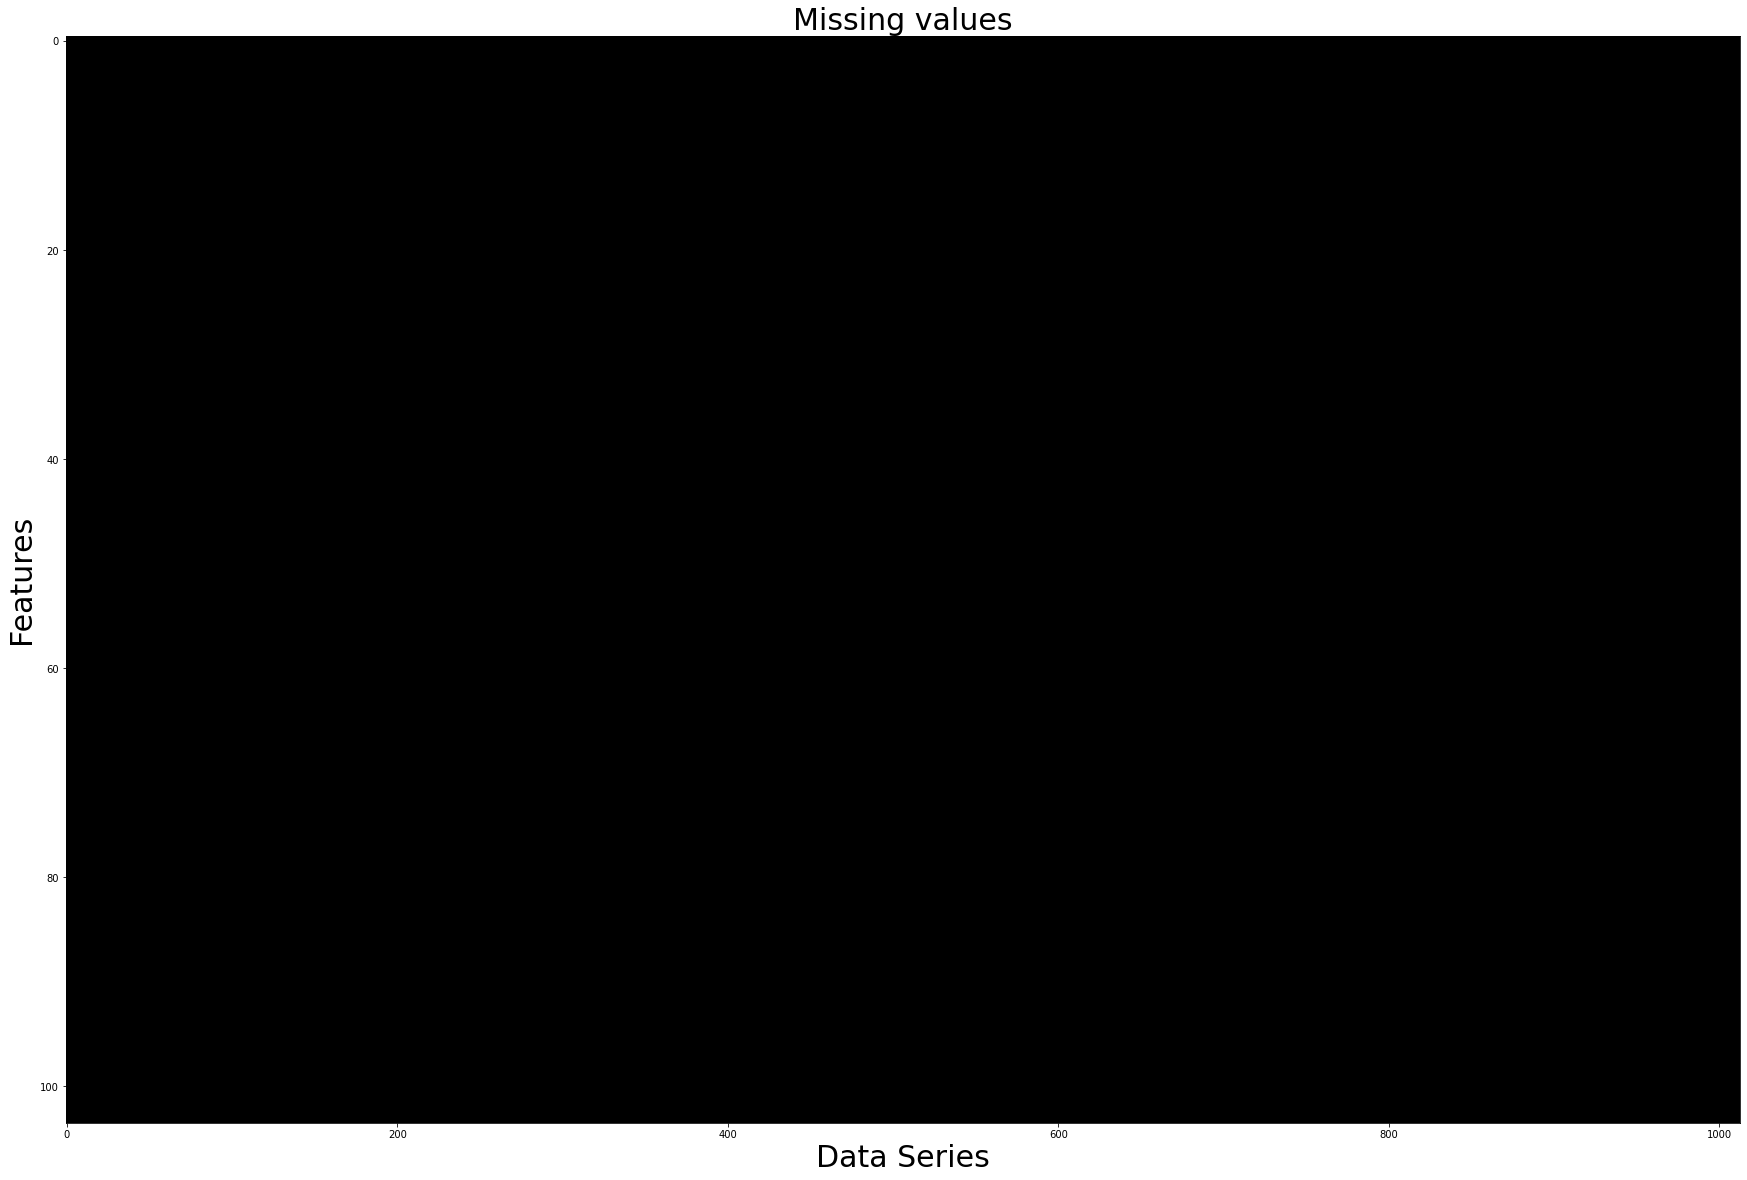

In [89]:
plt.figure(figsize=(30, 20))
plt.title('Missing values', fontsize=30)
plt.ylabel('Features', fontsize=30)
plt.xlabel('Data Series', fontsize=30)
plt.imshow(filtered_data.isna().T, cmap='gist_heat', aspect='auto')

In [21]:
filtered_data

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,805,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
3,34,1788,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,142,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
6,44,840,1,0.01,0.39,0.00,0.98,0.06,0.02,0.30,...,0.15,0.81,0.77,0.91,0.84,0.05,0.08,0.06,0.00,0.03
12,25,1059,1,0.03,0.47,0.01,0.96,0.13,0.02,0.29,...,0.22,0.66,0.82,0.66,0.73,0.03,0.18,0.59,0.00,0.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,9,1527,10,0.05,0.52,0.02,0.97,0.04,0.02,0.40,...,0.18,0.72,0.77,0.83,0.85,0.10,0.09,0.03,0.00,0.02
1987,44,217,10,0.01,0.65,0.00,1.00,0.01,0.01,0.40,...,0.06,0.77,0.65,0.84,0.71,0.16,0.02,0.02,0.00,0.04
1991,9,1708,10,0.16,0.37,0.25,0.69,0.04,0.25,0.35,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,1696,10,0.08,0.51,0.06,0.87,0.22,0.10,0.58,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


### Splitting and fitting
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold

In [22]:
from sklearn.model_selection import KFold #to split up the data into training and testing

In [23]:
features=filtered_data.columns[0:-1]

In [24]:
X = filtered_data[features]
y = filtered_data[filtered_data.columns[-1]]

In [25]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [26]:
lr = LinearRegression()

In [29]:
scores=[] #to store r squared
rmse_list=[] #to store RMSE
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.values[train_index], X.values[test_index], y.values[train_index], y.values[test_index]
    lr.fit(X_train, y_train)
    y_predict = lr.predict(X_test)
    scores.append(lr.score(X_test, y_test))
    rmse_fold = rmse(y_test, y_predict)
    rmse_list.append(rmse_fold)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

In [30]:
print("R Squared Mean: ", np.mean(scores))
print("R Squared STD: ", np.std(scores))
print("RMSE mean: ", np.mean(rmse_list))

R Squared Mean:  0.7298845619812842
R Squared STD:  0.02223214253675214
RMSE mean:  0.12949230101724551


### Lasso fit
* fit the best Lasso regression model with 5-fold grid search cross validation (GridSearchCV) on the parameters: alpha, normalize, max_iter and show the best parameters

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.linear_model import Lasso

In [32]:
np.arange(200,5000,100)

array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
       2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400,
       3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500,
       4600, 4700, 4800, 4900])

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV

In [33]:
parameters = {'alpha' : np.linspace(0.001,1.0,100),
              'normalize': (False, True),
             'max_iter': np.arange(200,5000,100)}
lf = Lasso()

In [167]:
clf = GridSearchCV(lf,parameters, cv=kf)
clf.fit(X_train, y_train)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([0.001     , 0.01109091,...
                         'max_iter': array([ 200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,
       2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400,
       3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500,
       4600, 4700, 4800, 4900]),
                         'normalize': (False, True)},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [168]:
clf.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=200,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [169]:
clf.best_score_

0.7333684100450494

In [170]:
y_pred = clf.best_estimator_.predict(X_test)

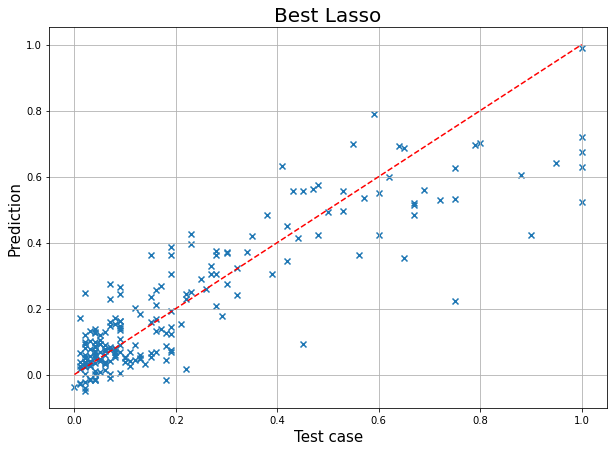

In [171]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred,marker='x')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('Test case',fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.title('Best Lasso',fontsize=20)
plt.grid(True)

## 3. Shrinkage

* interpret Lasso models based on its descriptive parameters by the shrinkage method described during the lecture (make a plot and check the names of the features that are not eliminated by the penalty parameter) on the data we have here [ this is an explanatory data analysis problem, try to be creative ]

* fit Ridge models and apply the shrinkage method as well, did you get what you expect?

* do you think normalization is needed here? if so, do not forget to use it in the next tasks

from http://patbaa.web.elte.hu/physdm/code_examples/model_regularization.html

In [39]:
from sklearn.linear_model import Ridge

In [40]:
def lasso(X,y):
    coefs = []
    alphs = []
    for alph in np.linspace(0.0001,1.0,10000):
        lass = Lasso(alpha=alph,normalize=False, max_iter=2000).fit(X,y)
        coefs.append(lass.coef_)
        alphs.append(alph)
    return np.array(alphs), np.array(coefs)

def ridge(X,y):
    coefs = []
    alphs = []
    for alph in np.linspace(0.0001,10.0,10000):
        lass = Ridge(alpha=alph,normalize=False, max_iter=2000).fit(X,y)
        coefs.append(lass.coef_)
        alphs.append(alph)
    return np.array(alphs), np.array(coefs)

In [41]:
lasso_alphas, lasso_coefs = lasso(X_train, y_train)

Text(0, 0.5, 'Coeffs')

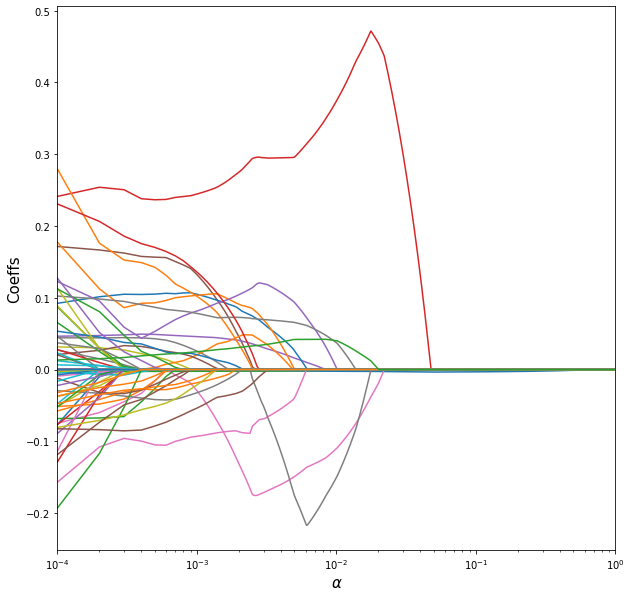

In [283]:
plt.figure(figsize=(10,10))
plt.plot(lasso_alphas, lasso_coefs)
plt.xlim(0.0001,1)
plt.xscale('log')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Coeffs', fontsize=15)

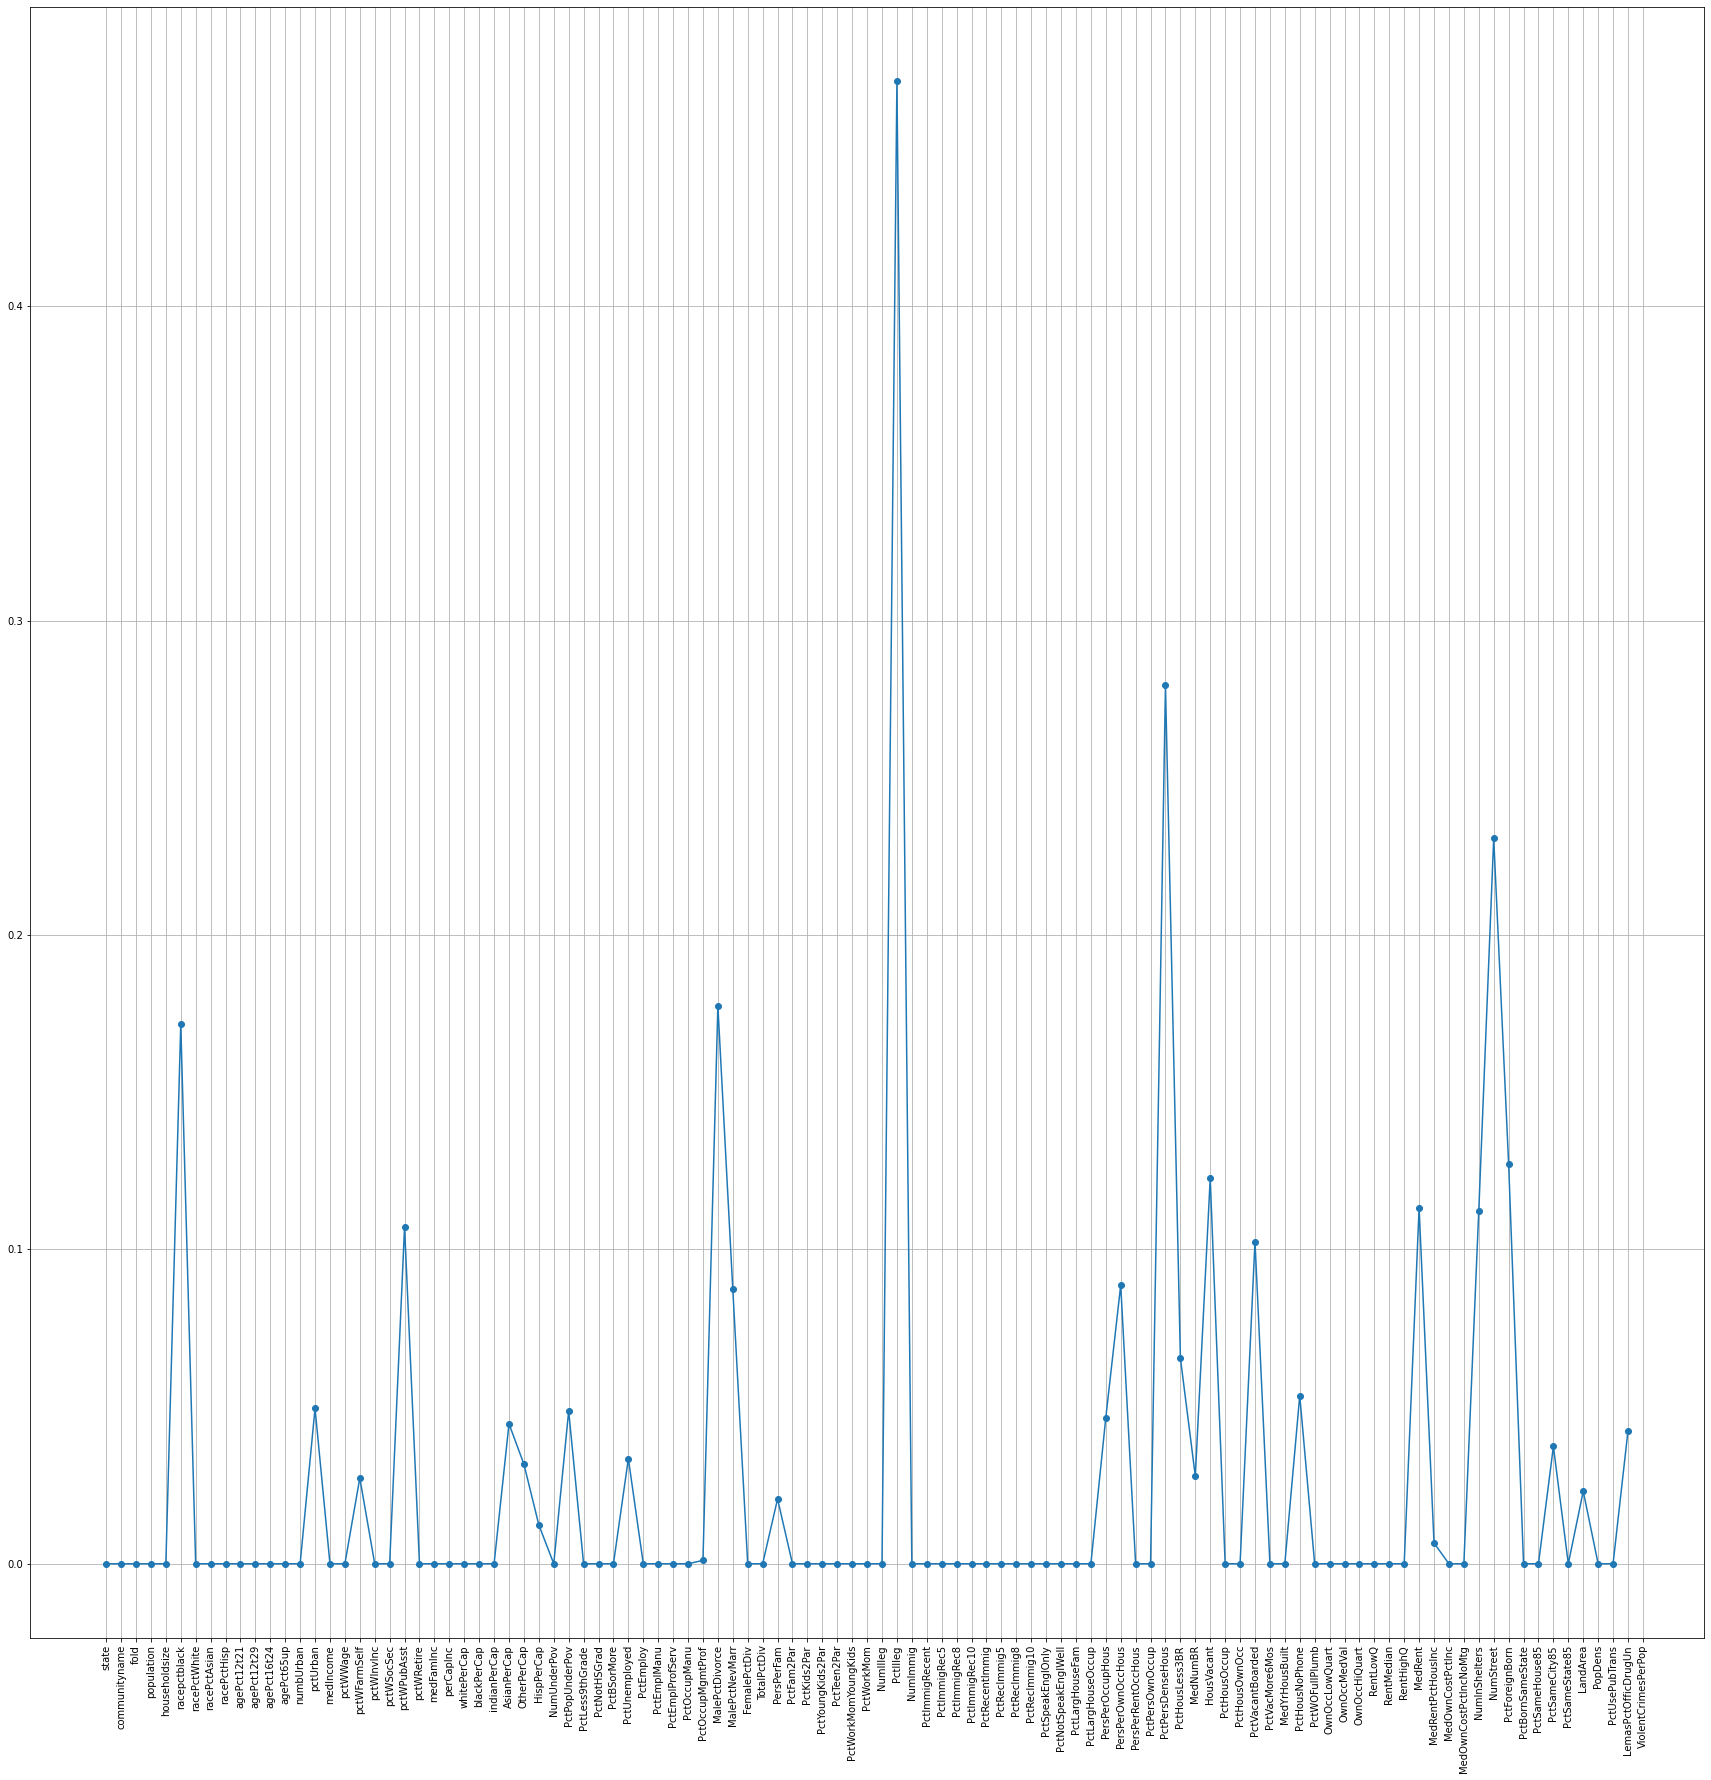

In [43]:
plt.figure(figsize=(30,30))
plt.plot(lasso_coefs.max(axis=0),'o-')
plt.xticks(ticks=np.arange(0,len(filtered_data.columns),1), labels=filtered_data.columns, rotation=90)
plt.grid(True)

<AxesSubplot:>

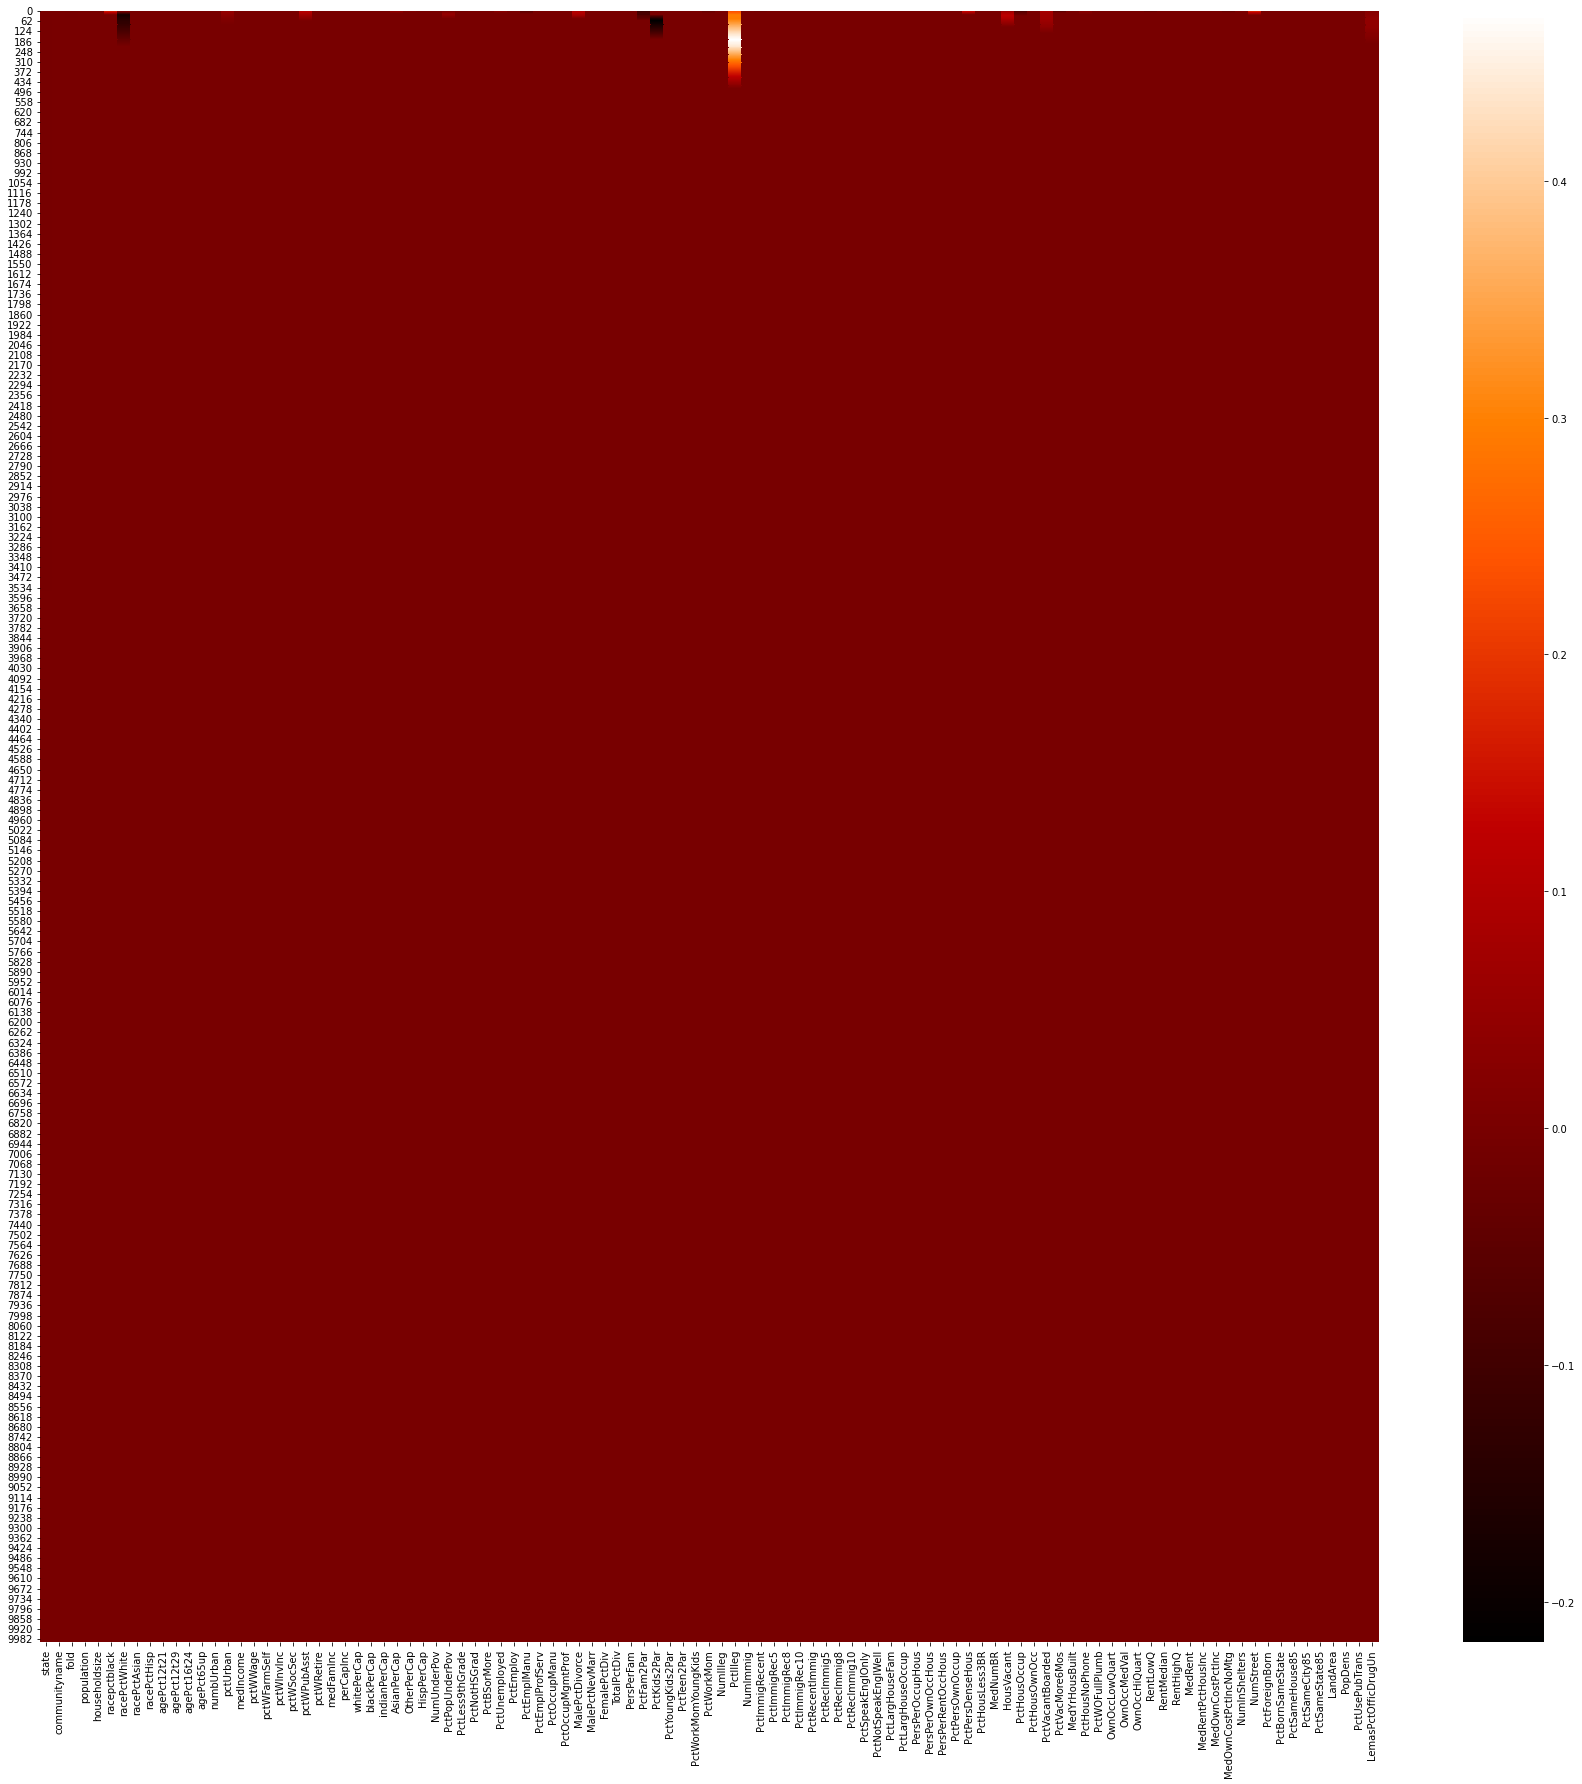

In [44]:
plt.figure(figsize=(30,30))
sns.heatmap(lasso_coefs,xticklabels=filtered_data.columns[:-1],cmap='gist_heat')

In [45]:
ridge_alphas, ridge_coefs = ridge(X_train, y_train)

Text(0, 0.5, 'Coeffs')

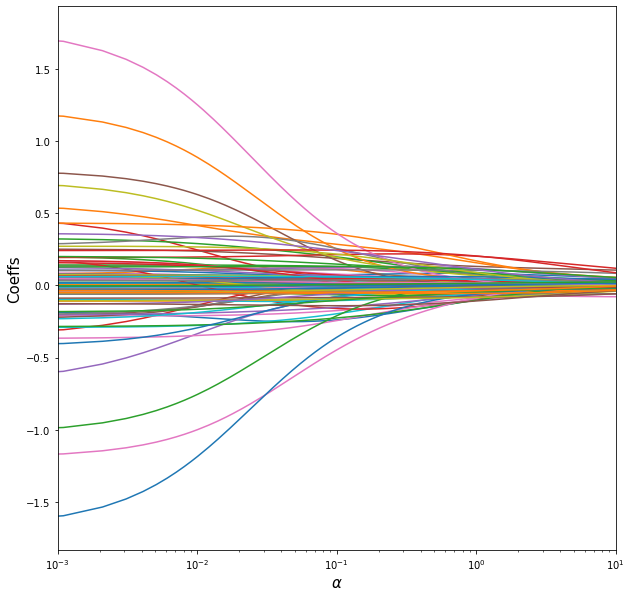

In [282]:
plt.figure(figsize=(10,10))
plt.plot(ridge_alphas, ridge_coefs)
plt.xlim(0.001,10)
plt.xscale('log')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Coeffs', fontsize=15)

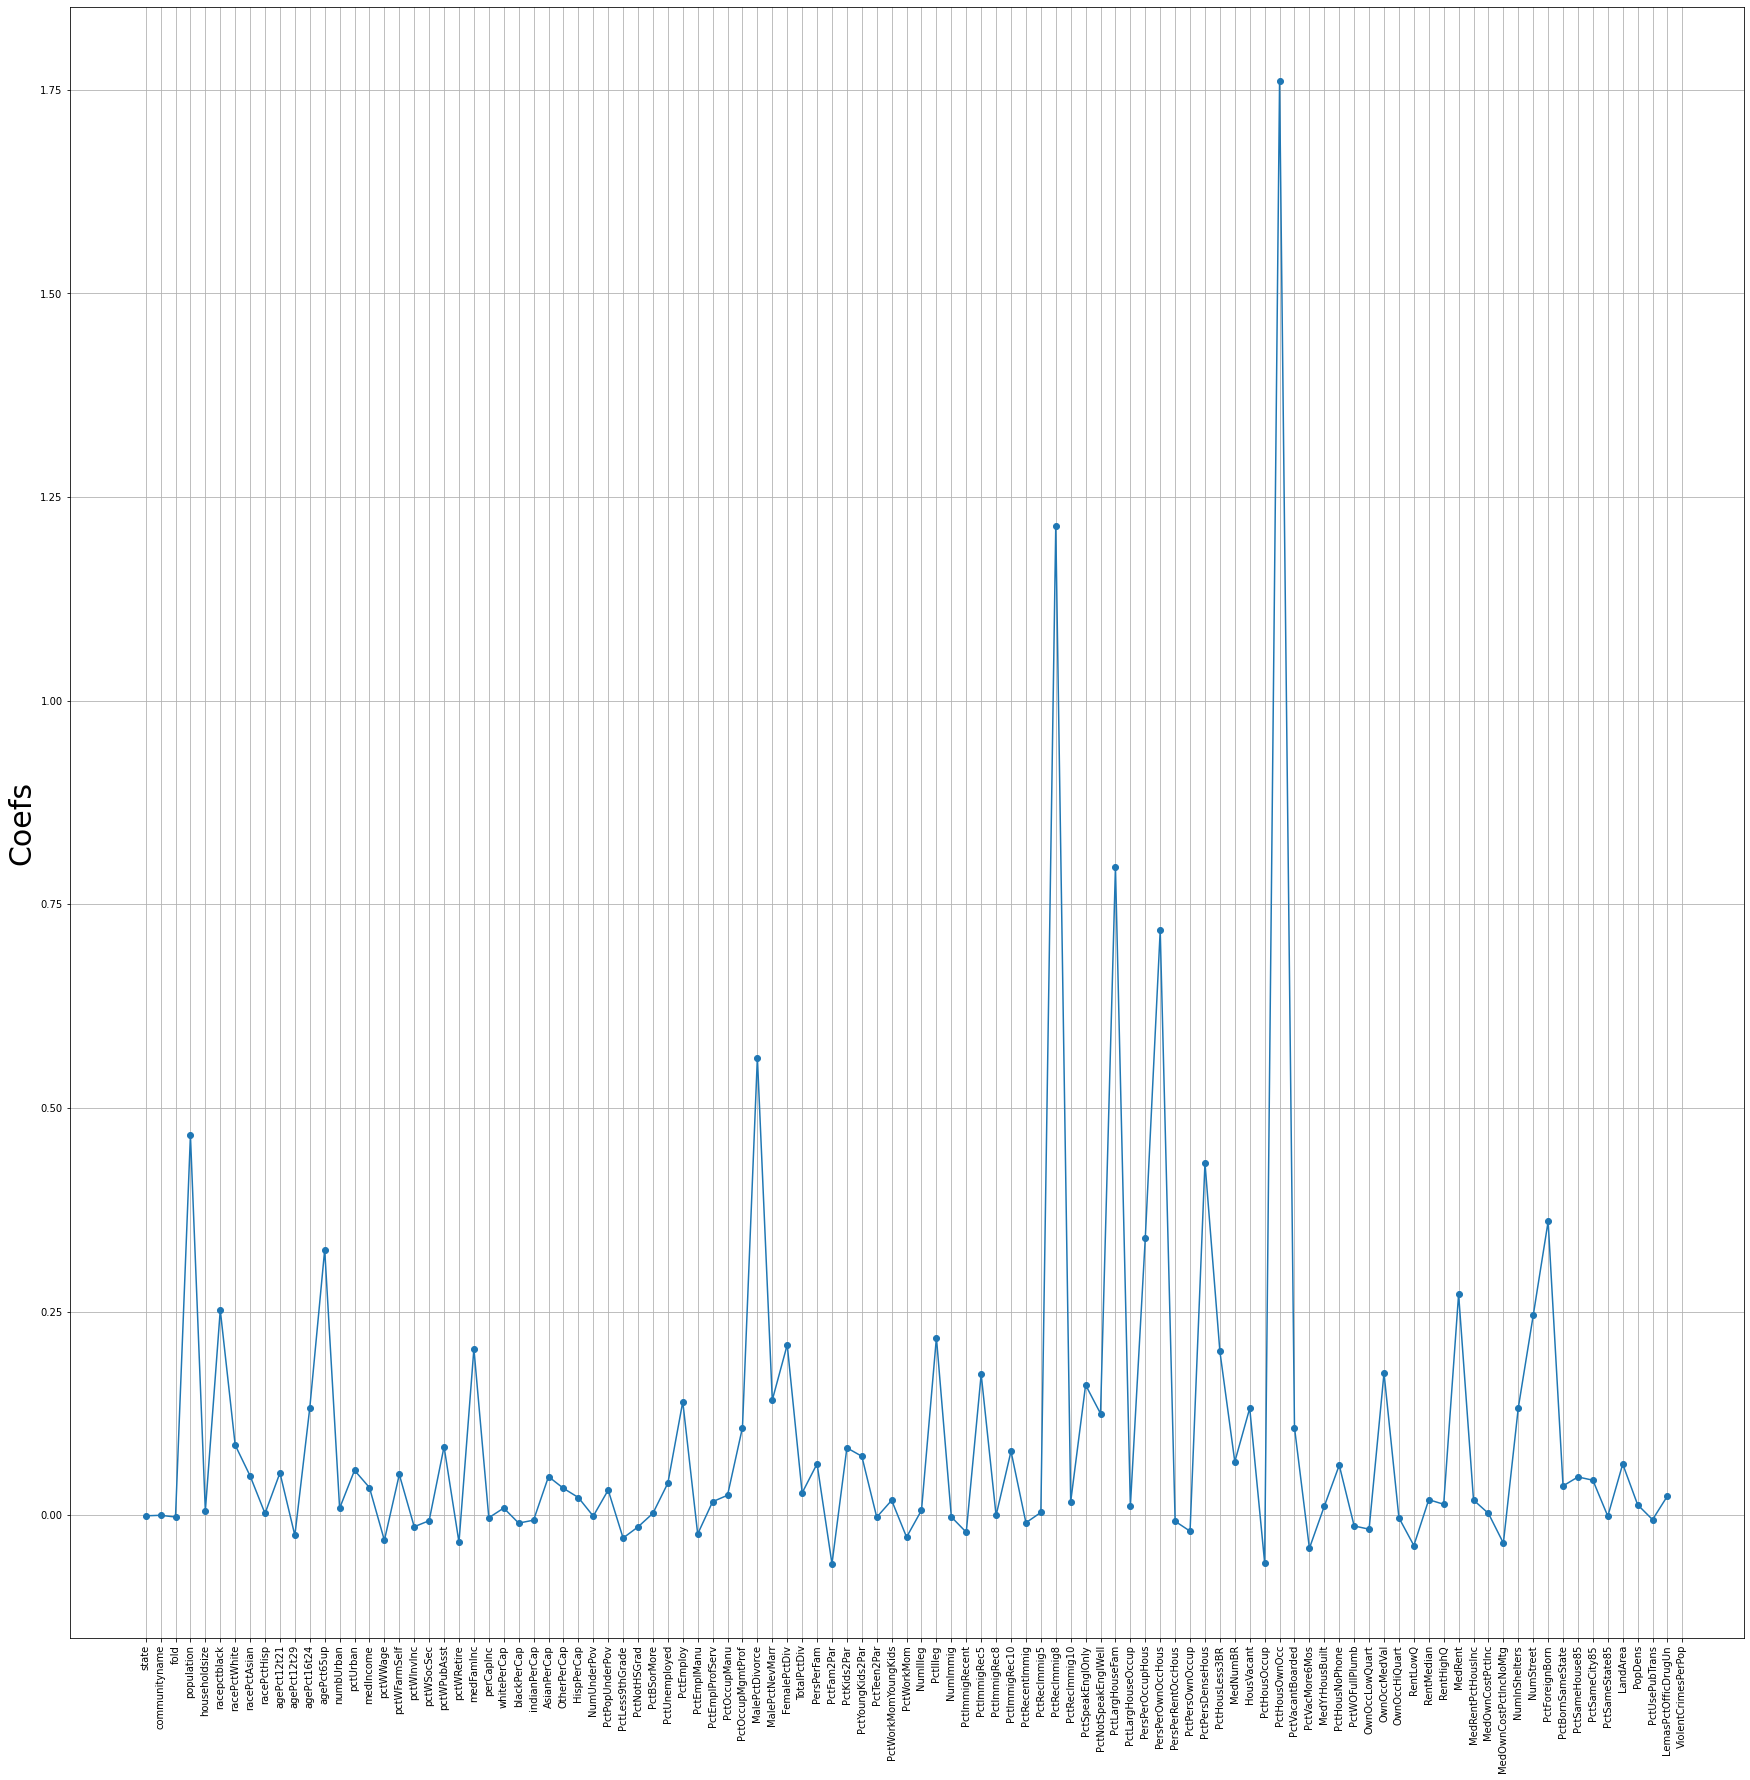

In [47]:
plt.figure(figsize=(30,30))
plt.plot(ridge_coefs.max(axis=0),'o-')
plt.xticks(ticks=np.arange(0,len(filtered_data.columns),1), labels=filtered_data.columns, rotation=90)
plt.ylabel('Coefs',fontsize=30)
plt.grid(True)

<AxesSubplot:>

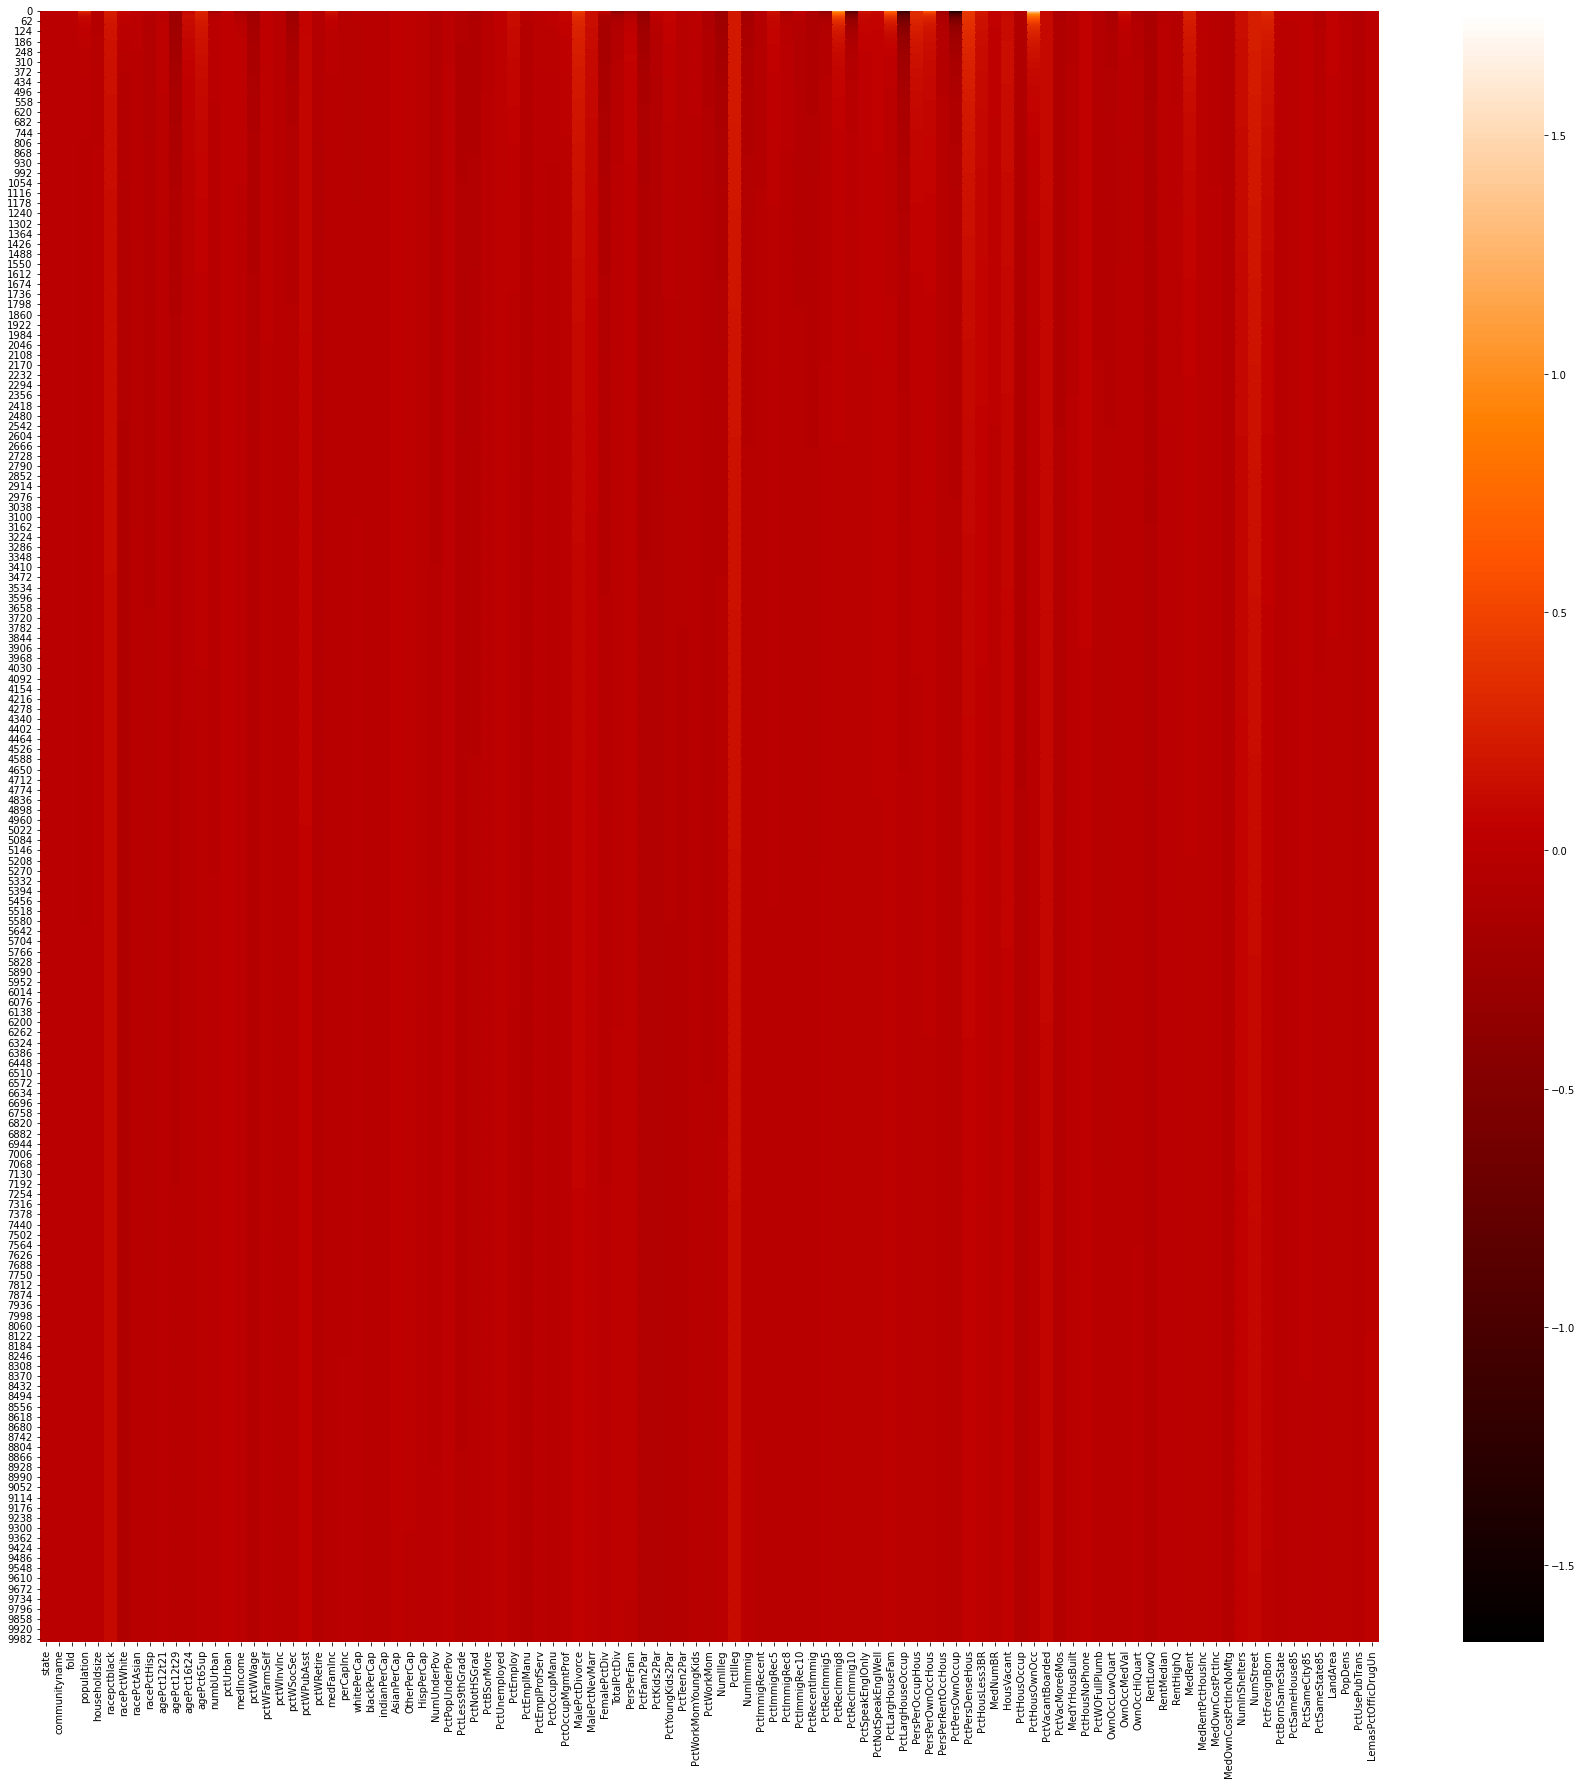

In [48]:
plt.figure(figsize=(30,30))
sns.heatmap(ridge_coefs,xticklabels=filtered_data.columns[:-1],cmap='gist_heat')

In [ ]:
from ipywidgets import *

def plotridge(it):
    plt.figure(figsize=(30,30))
    plt.plot(ridge_coefs[it])
    plt.xticks(ticks=np.arange(0,len(filtered_data.columns),1), labels=filtered_data.columns, rotation=90)
    plt.grid(True)

interact(plotridge,
         it=IntSlider(min=0,max=len(ridge_coefs),step=1,value=0,description=r'$\alpha$'))

#### According to the course, the lasso or L1 produces less parallel lines; while L2 shows colinear lines
This is what I was expecting and what I got. Penalty converges to 0 faster in Lasso but much later with Ridge

## 4. Subset selection

* Split the data to training and test sets and do recursice feature elimination until 10 remaining predictors with 5-fold cross-validated regressors (RidgeCV, LassoCV, ElasticNetCV) on the training set, plot their names and look up some of their meanings [ recursive feature elimination is part of sklearn but you can do it with a for loop if you whish ]

* Do all models provide the same descriptors? Check their performance on the test set! Plot all model predictions compared to the y_test on 3 different plots, which model seems to be the best?

In [50]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.feature_selection import RFE #recursive feature elemination

In [51]:
kf = KFold(n_splits=5)

### RidgeCV

In [59]:
r_cv = RidgeCV(alphas=np.linspace(0.0001,1.0,200),cv=kf)
r_rfe = RFE(estimator=r_cv, n_features_to_select=10,)

In [60]:
r_rfe.fit(X_train, y_train)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:167: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  support_ = np.ones(n_features, dtype=np.bool)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:794: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

RFE(estimator=RidgeCV(alphas=array([1.00000000e-04, 5.12462312e-03, 1.01492462e-02, 1.51738693e-02,
       2.01984925e-02, 2.52231156e-02, 3.02477387e-02, 3.52723618e-02,
       4.02969849e-02, 4.53216080e-02, 5.03462312e-02, 5.53708543e-02,
       6.03954774e-02, 6.54201005e-02, 7.04447236e-02, 7.54693467e-02,
       8.04939698e-02, 8.55185930e-02, 9.05432161e-02, 9.55678392e-02,
       1.00592462e-01...
       9.44729146e-01, 9.49753769e-01, 9.54778392e-01, 9.59803015e-01,
       9.64827638e-01, 9.69852261e-01, 9.74876884e-01, 9.79901508e-01,
       9.84926131e-01, 9.89950754e-01, 9.94975377e-01, 1.00000000e+00]),
                      cv=KFold(n_splits=5, random_state=None, shuffle=False),
                      fit_intercept=True, gcv_mode=None, normalize=False,
                      scoring=None, store_cv_values=False),
    n_features_to_select=10, step=1, verbose=0)

In [127]:
for i in range(len(r_rfe.estimator_.coef_)):
    print(filtered_data.columns[:-1][r_rfe.support_].values[i],r_rfe.estimator_.coef_[i])

agePct65up 0.4391735536857369
pctWWage -0.27177787144487303
pctWSocSec -0.642009785806632
PersPerFam 0.42317856526855746
PctKids2Par -0.3912929571031525
NumIlleg -0.3228371596910546
PctIlleg 0.39685643125668835
PctLargHouseOccup -0.06260979370614604
HousVacant 0.29972133430392706
NumStreet 0.2747153449891403


* agePct65up: percentage of population that is 65 and over in age
* pctWWage: percentage of households with wage or salary income in 1989
* pctWSocSec: percentage of households with social security income in 1989
* PersPerFam: mean number of people per family
* PctKids2Par: percentage of kids in family housing with two parents
* NumIlleg: number of kids born to never married
* PctIlleg: percentage of kids born to never married
* PctLargHouseOccup: percent of all occupied households that are large (6 or more people)
* HousVacant: number of vacant households
* NumStreet: number of homeless people counted in the street

In [151]:
print(r_rfe.estimator_.score)

<bound method RegressorMixin.score of RidgeCV(alphas=array([1.00000000e-04, 5.12462312e-03, 1.01492462e-02, 1.51738693e-02,
       2.01984925e-02, 2.52231156e-02, 3.02477387e-02, 3.52723618e-02,
       4.02969849e-02, 4.53216080e-02, 5.03462312e-02, 5.53708543e-02,
       6.03954774e-02, 6.54201005e-02, 7.04447236e-02, 7.54693467e-02,
       8.04939698e-02, 8.55185930e-02, 9.05432161e-02, 9.55678392e-02,
       1.00592462e-01, 1.05617085e-0...
       9.24630653e-01, 9.29655276e-01, 9.34679899e-01, 9.39704523e-01,
       9.44729146e-01, 9.49753769e-01, 9.54778392e-01, 9.59803015e-01,
       9.64827638e-01, 9.69852261e-01, 9.74876884e-01, 9.79901508e-01,
       9.84926131e-01, 9.89950754e-01, 9.94975377e-01, 1.00000000e+00]),
        cv=KFold(n_splits=5, random_state=None, shuffle=False),
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)>


In [61]:
ypred_rfe = r_rfe.predict(X_test)

In [152]:
print('RMSE:', rmse(ypred_rfe, y_test))

RMSE: 0.1283558802611519


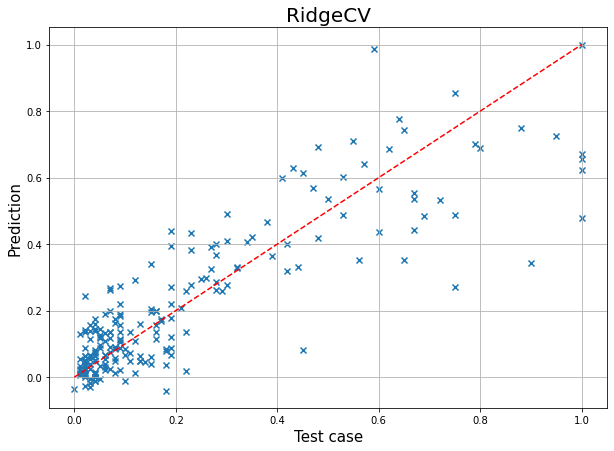

In [160]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, ypred_rfe,marker='x')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('Test case',fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.title('RidgeCV',fontsize=20)
plt.grid(True)

### LassoCV

In [153]:
l_cv = LassoCV(alphas=np.linspace(0.0001,1.0,200),cv=kf)
l_rfe = RFE(estimator=l_cv, n_features_to_select=10)

In [154]:
l_rfe.fit(X_train, y_train)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:167: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  support_ = np.ones(n_features, dtype=np.bool)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

RFE(estimator=LassoCV(alphas=array([1.00000000e-04, 5.12462312e-03, 1.01492462e-02, 1.51738693e-02,
       2.01984925e-02, 2.52231156e-02, 3.02477387e-02, 3.52723618e-02,
       4.02969849e-02, 4.53216080e-02, 5.03462312e-02, 5.53708543e-02,
       6.03954774e-02, 6.54201005e-02, 7.04447236e-02, 7.54693467e-02,
       8.04939698e-02, 8.55185930e-02, 9.05432161e-02, 9.55678392e-02,
       1.00592462e-01...
       9.64827638e-01, 9.69852261e-01, 9.74876884e-01, 9.79901508e-01,
       9.84926131e-01, 9.89950754e-01, 9.94975377e-01, 1.00000000e+00]),
                      copy_X=True,
                      cv=KFold(n_splits=5, random_state=None, shuffle=False),
                      eps=0.001, fit_intercept=True, max_iter=1000,
                      n_alphas=100, n_jobs=None, normalize=False,
                      positive=False, precompute='auto', random_state=None,
                      selection='cyclic', tol=0.0001, verbose=False),
    n_features_to_select=10, step=1, verbose=0)

In [155]:
for i in range(len(l_rfe.estimator_.coef_)):
    print(filtered_data.columns[:-1][l_rfe.support_].values[i],l_rfe.estimator_.coef_[i])

racepctblack 0.20778218103890211
pctWPubAsst 0.22573311472235338
PctLess9thGrade -0.14829808486889168
PctFam2Par -0.16081703938667372
NumIlleg -0.29550652598479593
PctIlleg 0.27809146668094614
PctPersDenseHous 0.2261102900064887
HousVacant 0.3070777026408804
NumStreet 0.24672781774182095
PctForeignBorn 0.027871587398618967


In [156]:
ypred_l_rfe = l_rfe.predict(X_test)

In [157]:
print('RMSE:', rmse(ypred_l_rfe, y_test))

RMSE: 0.1232399219948526


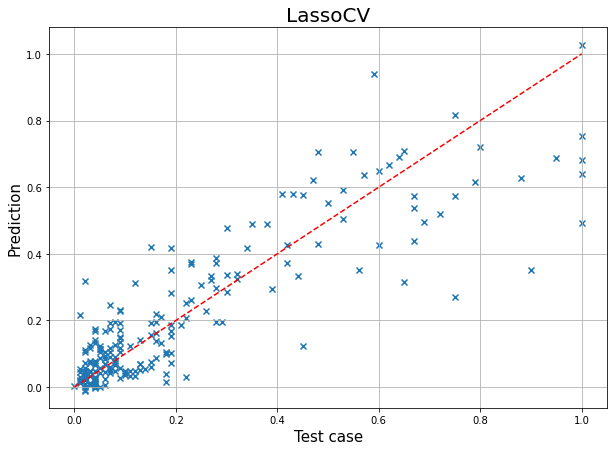

In [159]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, ypred_l_rfe,marker='x')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('Test case',fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.title('LassoCV',fontsize=20)
plt.grid(True)

### ElasticNetCV

In [161]:
e_cv = ElasticNetCV(alphas=np.linspace(0.0001,1.0,200),cv=kf)
e_rfe = RFE(estimator=e_cv, n_features_to_select=10,)

In [162]:
e_rfe.fit(X_train, y_train)

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:167: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  support_ = np.ones(n_features, dtype=np.bool)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/rfe.py:168: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0054630631066556745, tolerance: 0.003877311679506934
  tol, rng, random, positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013599970172350595, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012787950068581466, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012830293314490149, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012733335407027369, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012554414332441866, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012235136516725476, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011724274345342067, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011562513696913967, tolerance: 0.00506858451294698
  positive)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-pack

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` h

RFE(estimator=ElasticNetCV(alphas=array([1.00000000e-04, 5.12462312e-03, 1.01492462e-02, 1.51738693e-02,
       2.01984925e-02, 2.52231156e-02, 3.02477387e-02, 3.52723618e-02,
       4.02969849e-02, 4.53216080e-02, 5.03462312e-02, 5.53708543e-02,
       6.03954774e-02, 6.54201005e-02, 7.04447236e-02, 7.54693467e-02,
       8.04939698e-02, 8.55185930e-02, 9.05432161e-02, 9.55678392e-02,
       1.0059246...
       9.84926131e-01, 9.89950754e-01, 9.94975377e-01, 1.00000000e+00]),
                           copy_X=True,
                           cv=KFold(n_splits=5, random_state=None, shuffle=False),
                           eps=0.001, fit_intercept=True, l1_ratio=0.5,
                           max_iter=1000, n_alphas=100, n_jobs=None,
                           normalize=False, positive=False, precompute='auto',
                           random_state=None, selection='cyclic', tol=0.0001,
                           verbose=0),
    n_features_to_select=10, step=1, verbose=0)

In [163]:
for i in range(len(e_rfe.estimator_.coef_)):
    print(filtered_data.columns[:-1][e_rfe.support_].values[i],e_rfe.estimator_.coef_[i])

racepctblack 0.18051169610938286
pctWPubAsst 0.2825165375092356
NumUnderPov -0.2676928296005582
PctOccupManu -0.1627624557836015
MalePctDivorce 0.20846184045641986
PctIlleg 0.30048446084296493
PersPerOwnOccHous 0.04930026804306221
PctPersDenseHous 0.1983034319813658
HousVacant 0.3062097707265931
NumStreet 0.23264170282611735


In [164]:
ypred_e_rfe = e_rfe.predict(X_test)

In [165]:
print('RMSE:', rmse(ypred_e_rfe, y_test))

RMSE: 0.12316412138438224


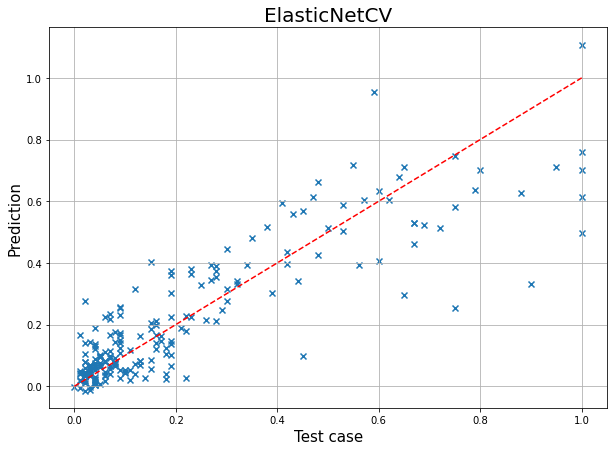

In [166]:
plt.figure(figsize=(10,7))
plt.scatter(y_test, ypred_e_rfe,marker='x')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('Test case',fontsize=15)
plt.ylabel('Prediction', fontsize=15)
plt.title('ElasticNetCV',fontsize=20)
plt.grid(True)

* best model seems to be Ridge, based on RMSE

# 5. ElasticNet penalty surface
* visualize the surface of the `objective(alpha, beta)`

 * parameters corresponding to the L1 and L2 regularizations. Select the best possible combination of the hyper-parameters that minimize the objective (clue: from scipy.optimize import minimize)

* this task is similar to what you've seen during class, just not for MSE vs. single penalty parameter but MSE vs. two penalty parameters `alpha, beta`

* interpret the overall results, do you think regularization is necessary at all? do you think linear models are powerful enough on this dataset?

#### same exercise just for Elastic

In [215]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [208]:
from scipy.optimize import minimize

In [273]:
def elasticnetMin(a, b):
    alpha = a + b
    L = a / (alpha)
    X,X_test, y, y_test = train_test_split(filtered_data[features],
                                           filtered_data[filtered_data.columns[-1]], train_size=0.6,
                                          random_state=137)
    ypred_el = ElasticNet(alpha=alpha,
                          normalize=False,
                          l1_ratio=L,
                          max_iter=50000,
                          random_state=137).fit(X,y).predict(X_test)
    return rmse(y_test,ypred_el)

In [293]:
np.shape(a)

(1000,)

In [305]:
a = np.linspace(0.0001,1.0,500)
b = np.linspace(0.0001,1.0,500)
res = np.zeros([len(a),len(b)])
print(np.shape(res))

for i in range(500):
    for j in range(500):
        res[i][j] = elasticnetMin(a[i],b[j])

(500, 500)


Text(249.0, 0.5, 'a')

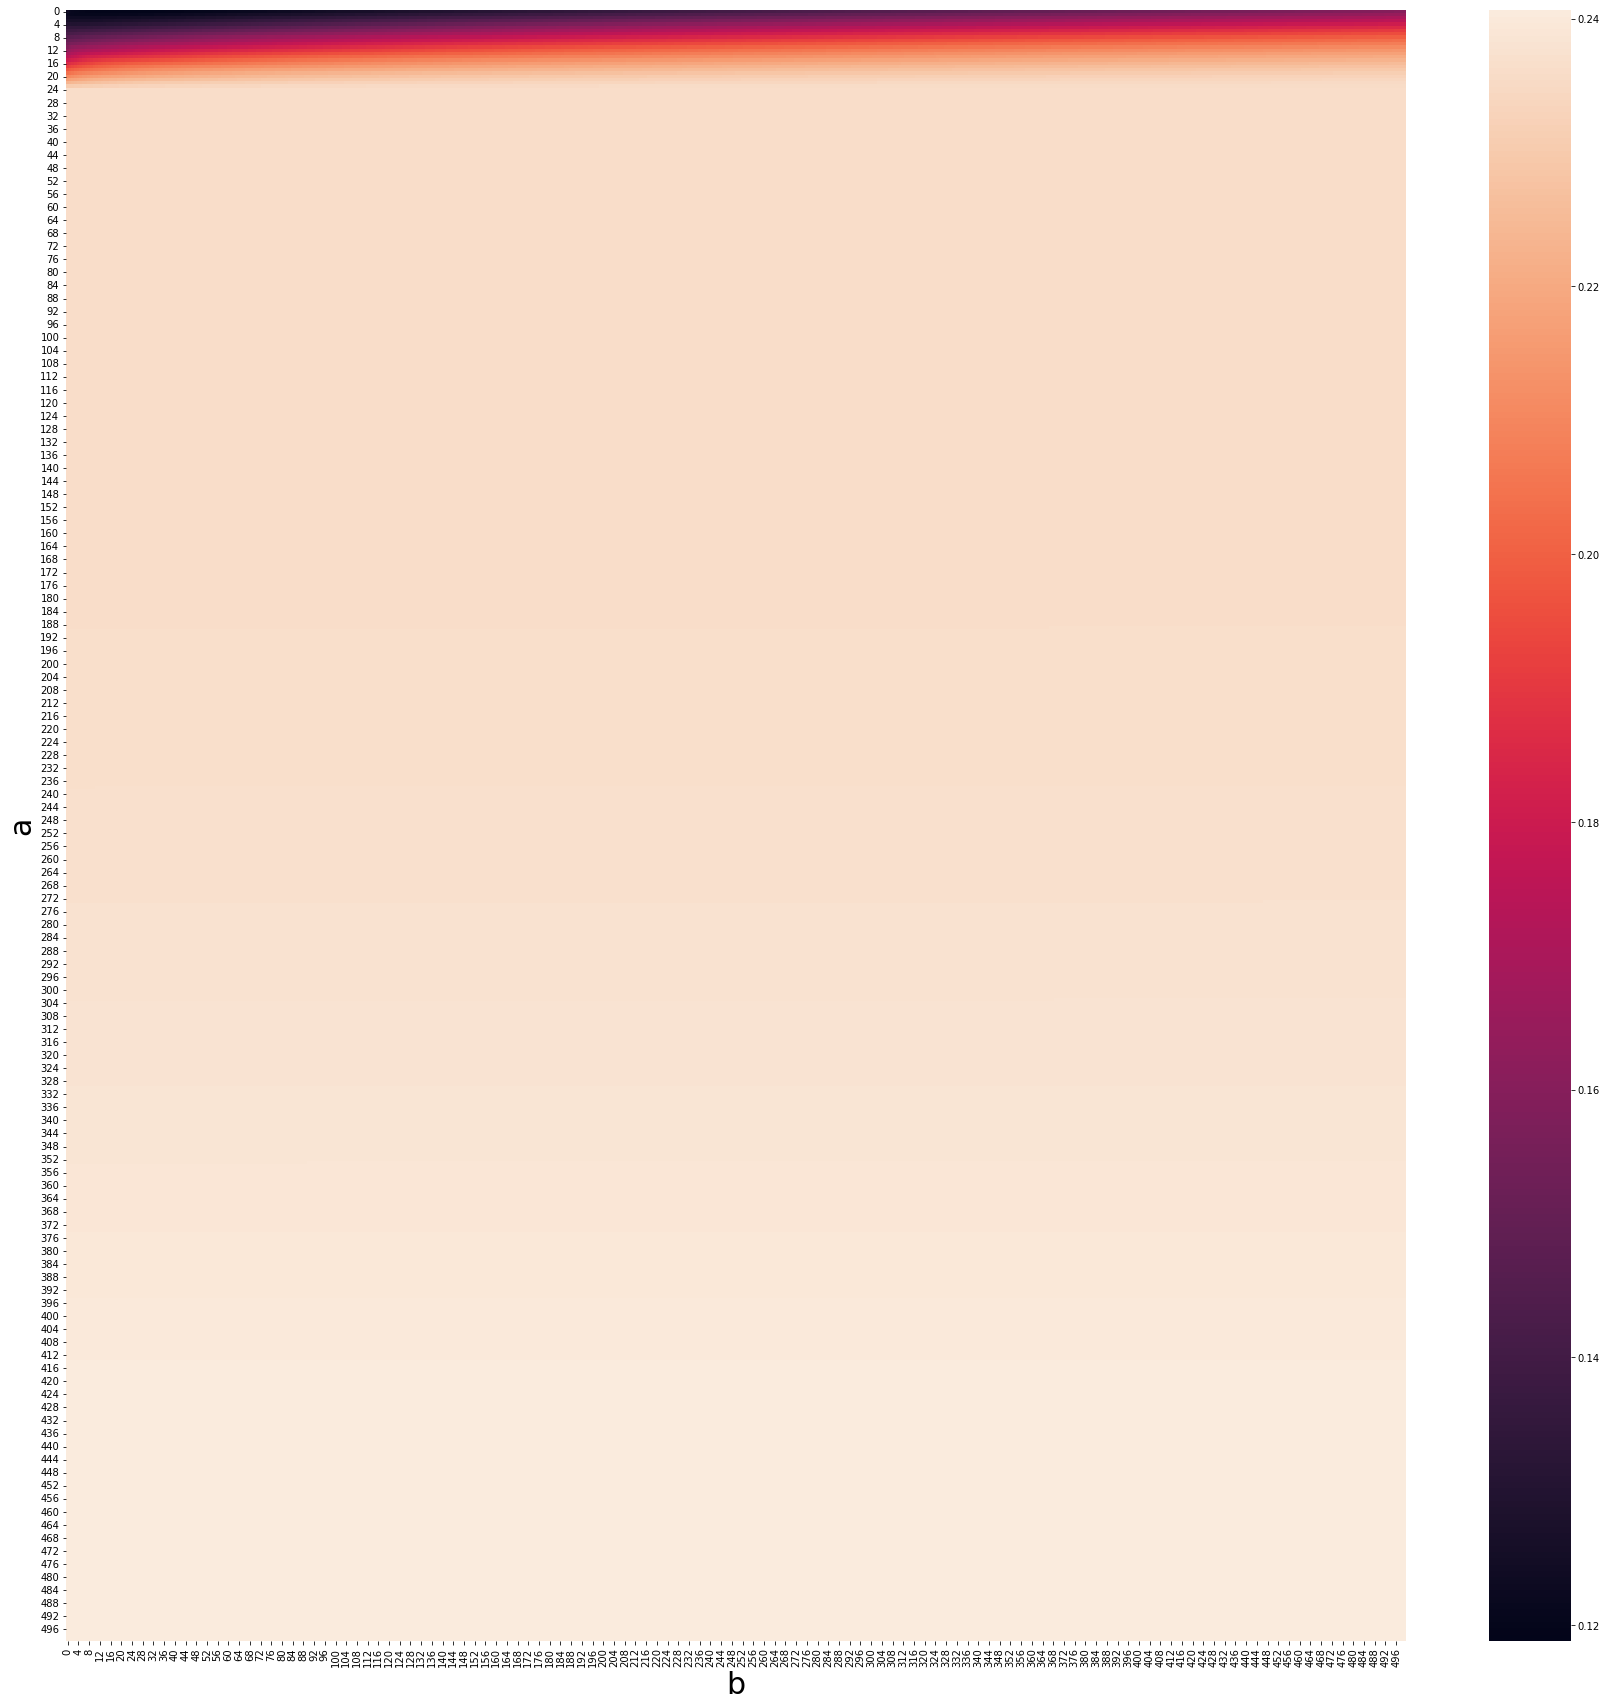

In [308]:
plt.figure(figsize=(30,30))
sns.heatmap(res)
plt.xlabel('b',fontsize=30)
plt.ylabel('a',fontsize=30)

In [254]:
res.hess_inv

<1x1 LbfgsInvHessProduct with dtype=float64>